# Analysis of New York City Neighborhoods
## For clients seeking to open a Jazz Coffeehouse / Performance Venue

### Let's start by downloading all the required packages for our analysis

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules

import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

### Now that our packages are installed let's download the New York City data set and pull the specific data we're interested in

In [2]:
# Get the NYC json data, this is publically available via an NYU-hosted site.
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
# Load the data into a json data set
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
# Pull only the data we need, which is all in the "features" group within the json data set
neighborhoods_data = newyork_data['features']

In [5]:
# Let's see what the first record looks like:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### Now that we have the data for NYC neighborhoods we'll create the dataframe with the just columns we need, then populate it

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
# Now populate the dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
# Let's take a look:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
neighborhoods.shape

(306, 4)

### Now we have the data including latitude and longitude for all 5 boroughs in New York City.

#### Let's pull the coordinates for Manhattan for now, we'll need this later when creating a cluster map

In [10]:
# This is for the cluster map
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


### Next, in order to pull venue details we'll need to set the FourSquare calls. This venue data will allow us to identify specific types of venues of interest.

In [11]:
CLIENT_ID = 'XKM1WICJGVYJNATDLMBDGCFTGX55SIKVEIFLD4U2IPJW5TIL' # your Foursquare ID
CLIENT_SECRET = 'AEROXK2QCML5HNEKG1G4RBYZIL0X5OOS1QP3VXOMDHSQAXC2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XKM1WICJGVYJNATDLMBDGCFTGX55SIKVEIFLD4U2IPJW5TIL
CLIENT_SECRET:AEROXK2QCML5HNEKG1G4RBYZIL0X5OOS1QP3VXOMDHSQAXC2


### Let's check the Latitude and Longitude of the first neighborhood

In [12]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


### Now we definte the Foursquare url. To include as many venues of interest as possible I have set the radius as 800 meters

In [13]:
# Now Define the Foursquare url NOTE updated radius to 800
LIMIT=100
radius=800
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, neighborhood_latitude, neighborhood_longitude, radius, LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=XKM1WICJGVYJNATDLMBDGCFTGX55SIKVEIFLD4U2IPJW5TIL&client_secret=AEROXK2QCML5HNEKG1G4RBYZIL0X5OOS1QP3VXOMDHSQAXC2&v=20180605&ll=40.89470517661,-73.84720052054902&radius=800&limit=100'

#### Let's check the results of this FourSquare call

In [14]:
# get the results of the url
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d6c23a2b77c77002c7e8941'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Wakefield',
  'headerFullLocation': 'Wakefield, Bronx',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 29,
  'suggestedBounds': {'ne': {'lat': 40.90190518381001,
    'lng': -73.8376934017105},
   'sw': {'lat': 40.88750516941, 'lng': -73.85670763938755}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c537892fd2ea593cb077a28',
       'name': 'Lollipops Gelato',
       'location': {'address': '4120 Baychester Ave',
        'crossStreet': 'Edenwald & Bussing Ave',
        'lat': 40.894123150205274,
        'lng': -

### We need to define a Function to get the category of the venue

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Next clean the JSON and structure it into a Pandas dataframe, then take a look at the results

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]


In [17]:
nearby_venues

,name,categories,lat,lng
0,Lollipops Gelato,Dessert Shop,40.894123,-73.845892
1,Rite Aid,Pharmacy,40.896649,-73.844846
2,Ripe Kitchen & Bar,Caribbean Restaurant,40.898152,-73.838875
3,Jackie's West Indian Bakery,Caribbean Restaurant,40.889283,-73.843310
4,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568
5,Rite Aid,Pharmacy,40.889062,-73.842993
6,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,40.898276,-73.850381
7,Dunkin',Donut Shop,40.890459,-73.849089
8,SUBWAY,Sandwich Place,40.890656,-73.849192
9,Walgreens,Pharmacy,40.898757,-73.854446


### Now we need to define a new function to get nearby venues for any neighborhood

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Let's get all the nearby venues and drop the data into a new dataframe for New York City venues, then we'll check it out

In [19]:
newyorkcity_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [20]:
# Check the new dataframe
print(newyorkcity_venues.shape)
newyorkcity_venues.head()

(10361, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


### For this project we will only be looking at specific venues that are related to the goals of our project.
### We'll create a new dataframe just for the venues of interest then take a quick look.


In [21]:
capstone_venues = ['Record Shop', 'Performing Arts Venue', 'Jazz Club', 'Concert Hall', 'Music School', 'Music Venue', 'Nightclub', 'Opera House', 'Coffee Shop']
filtered_venues=newyorkcity_venues[newyorkcity_venues['Venue Category'].isin(capstone_venues)]


In [22]:
filtered_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
78,Kingsbridge,40.881687,-73.902818,Mon Amour Coffee & Wine,40.885009,-73.900332,Coffee Shop
137,Marble Hill,40.876551,-73.910660,Starbucks,40.877531,-73.905582,Coffee Shop
146,Marble Hill,40.876551,-73.910660,Starbucks,40.873755,-73.908613,Coffee Shop
186,Norwood,40.877224,-73.879391,Nicky's Coffee Shop,40.874933,-73.879404,Coffee Shop
216,Williamsbridge,40.881039,-73.857446,Club Mystique,40.884149,-73.856476,Nightclub
250,Pelham Parkway,40.857413,-73.854756,Liberty Donut & Coffee Shop,40.855339,-73.855333,Coffee Shop
251,Pelham Parkway,40.857413,-73.854756,Bronx house,40.856689,-73.860467,Performing Arts Venue
274,City Island,40.847247,-73.786488,Starving Artist Cafe & Gallery,40.845420,-73.785806,Music Venue
322,Bedford Park,40.870185,-73.885512,National Coffee Shop,40.872841,-73.889053,Coffee Shop
368,Fordham,40.860997,-73.896427,Paradise Theater,40.860499,-73.898463,Music Venue


In [23]:
# Group the data by neighborhood and get a count of nearby venues for each
filtered_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arden Heights,1,1,1,1,1,1
Arlington,1,1,1,1,1,1
Arverne,1,1,1,1,1,1
Astoria,2,2,2,2,2,2
Bath Beach,1,1,1,1,1,1
Battery Park City,8,8,8,8,8,8
Bay Ridge,1,1,1,1,1,1
Bay Terrace,1,1,1,1,1,1
Bedford Park,1,1,1,1,1,1


In [24]:
# Find the total count of nearby venues by Venue Category
filtered_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Coffee Shop,274,274,274,274,274,274
Concert Hall,13,13,13,13,13,13
Jazz Club,10,10,10,10,10,10
Music School,3,3,3,3,3,3
Music Venue,25,25,25,25,25,25
Nightclub,14,14,14,14,14,14
Opera House,5,5,5,5,5,5
Performing Arts Venue,26,26,26,26,26,26
Record Shop,13,13,13,13,13,13


### It's clear that coffee shops are a lot more popular in New York City than music venues. This isn't unexpected, but it might be easier to execute our analysis if Coffee Shops and music-related venues are split. 
### First let's use OneHot encoding to make our data easier to work with

In [25]:
# one hot encoding
newyorkcity_onehot = pd.get_dummies(filtered_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyorkcity_onehot['Neighborhood'] = filtered_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyorkcity_onehot.columns[-1]] + list(newyorkcity_onehot.columns[:-1])
newyorkcity_onehot = newyorkcity_onehot[fixed_columns]

newyorkcity_onehot.head()

,Neighborhood,Coffee Shop,Concert Hall,Jazz Club,Music School,Music Venue,Nightclub,Opera House,Performing Arts Venue,Record Shop
78,Kingsbridge,1,0,0,0,0,0,0,0,0
137,Marble Hill,1,0,0,0,0,0,0,0,0
146,Marble Hill,1,0,0,0,0,0,0,0,0
186,Norwood,1,0,0,0,0,0,0,0,0
216,Williamsbridge,0,0,0,0,0,1,0,0,0


In [26]:
newyorkcity_onehot.shape

(383, 10)

### Let's create a dataframe just for coffee shops to help with our final analysis

In [27]:
# First create the df with just Neighborhood and Coffee Shop as columns
newyorkcity_onehot_coffee=newyorkcity_onehot[['Neighborhood','Coffee Shop']].groupby('Neighborhood').count()

#### Let's take a look at a sorted view to see which neighborhoods have the most coffee shops

In [28]:
# Sorted view
newyorkcity_coffee_sorted=newyorkcity_onehot_coffee.sort_values('Coffee Shop',ascending=False).reset_index()
newyorkcity_coffee_sorted.head(10)

,Neighborhood,Coffee Shop
0,Lincoln Square,12
1,East Williamsburg,11
2,Financial District,10
3,Greenpoint,10
4,Chelsea,10
5,Long Island City,9
6,Murray Hill,8
7,Battery Park City,8
8,West Village,8
9,Lenox Hill,7


### Now we need the neighborhood data without coffee shops included so that we can more easily execute analysis and group the results

In [29]:
# Drop "Coffee Shop" from the data set
newyorkcity_onehot_nocoffee=newyorkcity_onehot.drop(['Coffee Shop'], axis=1)

In [30]:
# Let's take a look
newyorkcity_onehot_nocoffee.head()

,Neighborhood,Concert Hall,Jazz Club,Music School,Music Venue,Nightclub,Opera House,Performing Arts Venue,Record Shop
78,Kingsbridge,0,0,0,0,0,0,0,0
137,Marble Hill,0,0,0,0,0,0,0,0
146,Marble Hill,0,0,0,0,0,0,0,0
186,Norwood,0,0,0,0,0,0,0,0
216,Williamsbridge,0,0,0,0,1,0,0,0


#### Let's check the average frequency for different categories

In [31]:
# Group by neighborhood and find the average frequency of each category
newyorkcity_grouped = newyorkcity_onehot_nocoffee.groupby('Neighborhood').mean().reset_index()
newyorkcity_grouped

,Neighborhood,Concert Hall,Jazz Club,Music School,Music Venue,Nightclub,Opera House,Performing Arts Venue,Record Shop
0,Arden Heights,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,Arlington,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,Arverne,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,Astoria,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Bath Beach,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
5,Battery Park City,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.125000,0.000000
6,Bay Ridge,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
7,Bay Terrace,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,Bedford Park,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Bedford Stuyvesant,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


### A lot of neighborhoods have zero musical venues, let's drop those rows

In [32]:
newyorkcity_grouped_nonzero = newyorkcity_grouped [~( newyorkcity_grouped \
                                                     [ ['Concert Hall',  'Jazz Club',   'Music School',  'Music Venue', 'Nightclub',  \
                                                        'Opera House',  'Performing Arts Venue', 'Record Shop', ] ] == 0).all(axis=1) ]

In [33]:
# Reset the index
newyorkcity_grouped_nonzero = newyorkcity_grouped_nonzero.reset_index(drop=True)

In [34]:
# Let's take a look
print(newyorkcity_grouped_nonzero.shape)
newyorkcity_grouped_nonzero.head(10)

(58, 9)


,Neighborhood,Concert Hall,Jazz Club,Music School,Music Venue,Nightclub,Opera House,Performing Arts Venue,Record Shop
0,Battery Park City,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.125000,0.000000
1,Boerum Hill,0.142857,0.0,0.0,0.142857,0.000000,0.0,0.142857,0.000000
2,Bronxdale,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000
3,Brownsville,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000
4,Bushwick,0.000000,0.0,0.0,0.142857,0.142857,0.0,0.000000,0.000000
5,Cambria Heights,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000
6,Carroll Gardens,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.166667
7,Central Harlem,0.000000,0.5,0.0,0.500000,0.000000,0.0,0.000000,0.000000
8,Charleston,0.000000,0.0,0.0,0.500000,0.000000,0.0,0.000000,0.000000
9,Chelsea,0.000000,0.0,0.0,0.000000,0.400000,0.0,0.000000,0.000000


### Let's print each neighborhood with its top 3 venues

In [35]:
num_top_venues = 3

for hood in newyorkcity_grouped_nonzero['Neighborhood']:
    print("----"+hood+"----")
    temp = newyorkcity_grouped_nonzero[newyorkcity_grouped_nonzero['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                   venue  freq
0  Performing Arts Venue  0.12
1           Concert Hall  0.00
2              Jazz Club  0.00


----Boerum Hill----
                   venue  freq
0           Concert Hall  0.14
1            Music Venue  0.14
2  Performing Arts Venue  0.14


----Bronxdale----
                   venue  freq
0  Performing Arts Venue   1.0
1           Concert Hall   0.0
2              Jazz Club   0.0


----Brownsville----
                   venue  freq
0  Performing Arts Venue   1.0
1           Concert Hall   0.0
2              Jazz Club   0.0


----Bushwick----
          venue  freq
0   Music Venue  0.14
1     Nightclub  0.14
2  Concert Hall  0.00


----Cambria Heights----
          venue  freq
0     Nightclub   1.0
1  Concert Hall   0.0
2     Jazz Club   0.0


----Carroll Gardens----
          venue  freq
0   Record Shop  0.17
1  Concert Hall  0.00
2     Jazz Club  0.00


----Central Harlem----
          venue  freq
0     Jazz Club   0.5
1   Music 

### Create a formula to return the most common venues

In [36]:
# Define a formula to return the most common venues:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Since we have only eight categories we'll pull only the top 3

In [37]:
# Set the number of top venues to 3
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyorkcity_grouped_nonzero['Neighborhood']

for ind in np.arange(newyorkcity_grouped_nonzero.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyorkcity_grouped_nonzero.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Battery Park City,Performing Arts Venue,Record Shop,Opera House
1,Boerum Hill,Performing Arts Venue,Music Venue,Concert Hall
2,Bronxdale,Performing Arts Venue,Record Shop,Opera House
3,Brownsville,Performing Arts Venue,Record Shop,Opera House
4,Bushwick,Nightclub,Music Venue,Record Shop


### We'll use clustering analysis to help group neighborhoods for analysis.
### Next we'll determine how many clusters should be used for our KNN clustering analysis. 


In [38]:
# drop Neighnorhood for clustering purposes so we can focus on the venues
newyorkcity_grouped_clustering = newyorkcity_grouped_nonzero.drop('Neighborhood', 1)

import matplotlib.pyplot as plt

#### Let's start with the "Elbow Method" to see if we can find a good inflection point

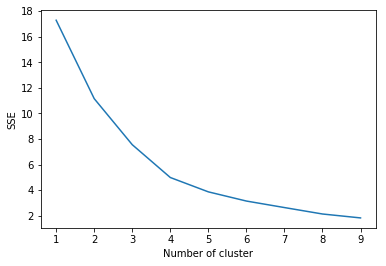

In [39]:
## Test to see if SSE number of clusters will work

sse = {}
for kclusters in range(1, 10):
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyorkcity_grouped_clustering)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[kclusters] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### Although there is a slight "elbow" at 4 the SSE is still fairly high. There is a slight inflection point at 6 clusters and the rate of improvement seems to slow after that. 
### Let's also try Silhouette scores - for this the goal is to identify the number of clusters with the highest score

In [40]:
from sklearn.metrics import silhouette_score

In [41]:
# Silhouette scores
for n_clusters in range(2, 10):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(newyorkcity_grouped_clustering)
    centers = clusterer.cluster_centers_

    score = silhouette_score (newyorkcity_grouped_clustering, preds, metric='euclidean',random_state=5)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.45585940979159584)
For n_clusters = 3, silhouette score is 0.5345413017829335)
For n_clusters = 4, silhouette score is 0.4960246951247872)
For n_clusters = 5, silhouette score is 0.4565096527640867)
For n_clusters = 6, silhouette score is 0.4314958367096974)
For n_clusters = 7, silhouette score is 0.46316365273805365)
For n_clusters = 8, silhouette score is 0.43108337971326227)
For n_clusters = 9, silhouette score is 0.4410794875598237)


### Between 6 and 8 looks like the balance of low SSE and higher silhouette score. I will use 7 since it represents a good balance for our data set, which is not large.


### Cluster the neighborhoods

In [42]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyorkcity_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 6, 6, 4, 0, 4, 1, 4, 4], dtype=int32)

### Create a new dataframe merging Neighborhoods with clusters and venues

In [43]:
# add clustering labels
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels', 1)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

newyorkcity_merged = neighborhoods

# merge New York City venue data with the Neighborhoods data to add latitude/longitude for each neighborhood
newyorkcity_merged = newyorkcity_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newyorkcity_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,NaN,NaN,NaN,NaN
1,Bronx,Co-op City,40.874294,-73.829939,NaN,NaN,NaN,NaN
2,Bronx,Eastchester,40.887556,-73.827806,NaN,NaN,NaN,NaN
3,Bronx,Fieldston,40.895437,-73.905643,NaN,NaN,NaN,NaN
4,Bronx,Riverdale,40.890834,-73.912585,NaN,NaN,NaN,NaN


### There seem to be some neighborhoods with no data, let's drop those

In [44]:
newyorkcity_merged = newyorkcity_merged.dropna(axis = 0, how ='any')
newyorkcity_merged = newyorkcity_merged.reset_index(drop=True)

In [45]:
newyorkcity_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Bronx,Williamsbridge,40.881039,-73.857446,0.0,Nightclub,Record Shop,Performing Arts Venue
1,Bronx,Pelham Parkway,40.857413,-73.854756,2.0,Performing Arts Venue,Record Shop,Opera House
2,Bronx,City Island,40.847247,-73.786488,3.0,Music Venue,Record Shop,Performing Arts Venue
3,Bronx,Fordham,40.860997,-73.896427,3.0,Music Venue,Record Shop,Performing Arts Venue
4,Bronx,Port Morris,40.801664,-73.913221,3.0,Music Venue,Record Shop,Performing Arts Venue


### Looks better but Cluster Labels are Float, not Int. Let's convert that column

In [46]:
newyorkcity_merged['Cluster Labels'] = newyorkcity_merged['Cluster Labels'].astype(int)

In [47]:
newyorkcity_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Bronx,Williamsbridge,40.881039,-73.857446,0,Nightclub,Record Shop,Performing Arts Venue
1,Bronx,Pelham Parkway,40.857413,-73.854756,2,Performing Arts Venue,Record Shop,Opera House
2,Bronx,City Island,40.847247,-73.786488,3,Music Venue,Record Shop,Performing Arts Venue
3,Bronx,Fordham,40.860997,-73.896427,3,Music Venue,Record Shop,Performing Arts Venue
4,Bronx,Port Morris,40.801664,-73.913221,3,Music Venue,Record Shop,Performing Arts Venue


### Let's visualize the Clusters

In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyorkcity_merged['Latitude'], newyorkcity_merged['Longitude'], newyorkcity_merged['Neighborhood'], newyorkcity_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Let's examine each cluster to see which might represent the best targets for our project

In [49]:
newyorkcity_merged.loc[newyorkcity_merged['Cluster Labels'] == 0, newyorkcity_merged.columns[[1] + list(range(5, newyorkcity_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Williamsbridge,Nightclub,Record Shop,Performing Arts Venue
19,Flatlands,Nightclub,Record Shop,Performing Arts Venue
47,Cambria Heights,Nightclub,Record Shop,Performing Arts Venue
50,Great Kills,Nightclub,Record Shop,Performing Arts Venue


In [50]:
newyorkcity_merged.loc[newyorkcity_merged['Cluster Labels'] == 1, newyorkcity_merged.columns[[1] + list(range(5, newyorkcity_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
7,Manhattan Terrace,Jazz Club,Record Shop,Performing Arts Venue
24,Prospect Lefferts Gardens,Record Shop,Music Venue,Jazz Club
29,Central Harlem,Music Venue,Jazz Club,Record Shop
41,West Village,Jazz Club,Performing Arts Venue,Record Shop


In [51]:
newyorkcity_merged.loc[newyorkcity_merged['Cluster Labels'] == 2, newyorkcity_merged.columns[[1] + list(range(5, newyorkcity_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Pelham Parkway,Performing Arts Venue,Record Shop,Opera House
12,Cobble Hill,Performing Arts Venue,Record Shop,Opera House
16,Fort Greene,Performing Arts Venue,Opera House,Record Shop
17,Park Slope,Performing Arts Venue,Record Shop,Opera House
22,Downtown,Performing Arts Venue,Record Shop,Opera House
30,East Harlem,Performing Arts Venue,Record Shop,Opera House
32,Lincoln Square,Concert Hall,Performing Arts Venue,Opera House
45,Flushing,Performing Arts Venue,Record Shop,Opera House
46,Jamaica Center,Performing Arts Venue,Concert Hall,Record Shop
54,Midtown South,Performing Arts Venue,Record Shop,Opera House


In [52]:
newyorkcity_merged.loc[newyorkcity_merged['Cluster Labels'] == 3, newyorkcity_merged.columns[[1] + list(range(5, newyorkcity_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,City Island,Music Venue,Record Shop,Performing Arts Venue
3,Fordham,Music Venue,Record Shop,Performing Arts Venue
4,Port Morris,Music Venue,Record Shop,Performing Arts Venue
8,Kensington,Music Venue,Record Shop,Performing Arts Venue
18,East New York,Music Venue,Record Shop,Performing Arts Venue
20,Coney Island,Music Venue,Record Shop,Performing Arts Venue
21,Clinton Hill,Music Venue,Record Shop,Performing Arts Venue
58,Erasmus,Music Venue,Record Shop,Performing Arts Venue


In [53]:
newyorkcity_merged.loc[newyorkcity_merged['Cluster Labels'] == 4, newyorkcity_merged.columns[[1] + list(range(5, newyorkcity_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
6,Greenpoint,Record Shop,Nightclub,Performing Arts Venue
9,Prospect Heights,Music Venue,Record Shop,Performing Arts Venue
11,Bushwick,Nightclub,Music Venue,Record Shop
13,Carroll Gardens,Record Shop,Performing Arts Venue,Opera House
14,Red Hook,Record Shop,Performing Arts Venue,Opera House
15,Gowanus,Record Shop,Performing Arts Venue,Nightclub
23,Boerum Hill,Performing Arts Venue,Music Venue,Concert Hall
25,East Williamsburg,Concert Hall,Music Venue,Record Shop
26,South Side,Nightclub,Music Venue,Record Shop
27,Chinatown,Record Shop,Music Venue,Performing Arts Venue


In [54]:
newyorkcity_merged.loc[newyorkcity_merged['Cluster Labels'] == 5, newyorkcity_merged.columns[[1] + list(range(5, newyorkcity_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
5,Sunset Park,Record Shop,Performing Arts Venue,Opera House


In [55]:
newyorkcity_merged.loc[newyorkcity_merged['Cluster Labels'] == 6, newyorkcity_merged.columns[[1] + list(range(5, newyorkcity_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
10,Brownsville,Performing Arts Venue,Record Shop,Opera House
49,Stapleton,Performing Arts Venue,Record Shop,Opera House
57,Bronxdale,Performing Arts Venue,Record Shop,Opera House


### Observations
* Cluster 4 has an interesting blend of jazz clubs and music venues as most popular, some of these neighborhoods should be in scope.
* The neighborhoods in Cluster 1 also seem to be excellent candidates for further exploration
* The other clusters have neighborhoods with music-related venues but a low density of Jazz Clubs specifically, something we are looking for.


### I'll choose any neighborhood from cluster 4 that has Jazz Club as the 1st most common venue, plus all 4 neighborhoods in cluster 6: 
* Upper East Side
* Murray Hill
* Manhattan Terrace
* Prospect Lefferts Gardens
* Central Harlem
* Greenwich Village
* West Village

### Let's also include neighborhoods in cluster 4 that have Night Club as the 1st most common venue:
* Hudson Yards
* Grammercy
* Chelsea
* Bushwick
* South Side

In [59]:
target_neigh = ['Upper East Side', 'Murray Hill', 'Manhattan Terrace', 'Prospect Lefferts Gardens', 'Central Harlem', 'Greenwich Village', \
                        'West Village', 'Hudson Yards', 'Grammercy', 'Chelsea', 'Bushwick', 'South Side']
target_neighborhoods=newyorkcity_merged[newyorkcity_merged['Neighborhood'].isin(target_neigh)]
target_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
7,Brooklyn,Manhattan Terrace,40.614433,-73.957438,1,Jazz Club,Record Shop,Performing Arts Venue
11,Brooklyn,Bushwick,40.698116,-73.925258,4,Nightclub,Music Venue,Record Shop
24,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,1,Record Shop,Music Venue,Jazz Club
26,Brooklyn,South Side,40.710861,-73.958001,4,Nightclub,Music Venue,Record Shop
29,Manhattan,Central Harlem,40.815976,-73.943211,1,Music Venue,Jazz Club,Record Shop


### Let's drop Cluster Labels as well

In [60]:
target_neighborhoods.drop('Cluster Labels', axis=1, inplace=True)
target_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
7,Brooklyn,Manhattan Terrace,40.614433,-73.957438,Jazz Club,Record Shop,Performing Arts Venue
11,Brooklyn,Bushwick,40.698116,-73.925258,Nightclub,Music Venue,Record Shop
24,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,Record Shop,Music Venue,Jazz Club
26,Brooklyn,South Side,40.710861,-73.958001,Nightclub,Music Venue,Record Shop
29,Manhattan,Central Harlem,40.815976,-73.943211,Music Venue,Jazz Club,Record Shop


### Now we can merge in our coffee data 

In [61]:
# merge target_neighborhoods with coffee data
target_neigh_coffee = target_neighborhoods.join(newyorkcity_coffee_sorted.set_index('Neighborhood'), on='Neighborhood')

# Sort by number of coffee shopsleast
target_neigh_coffee.sort_values('Coffee Shop')

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Coffee Shop
7,Brooklyn,Manhattan Terrace,40.614433,-73.957438,Jazz Club,Record Shop,Performing Arts Venue,2
29,Manhattan,Central Harlem,40.815976,-73.943211,Music Venue,Jazz Club,Record Shop,2
24,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,Record Shop,Music Venue,Jazz Club,3
37,Manhattan,Greenwich Village,40.726933,-73.999914,Record Shop,Jazz Club,Performing Arts Venue,4
31,Manhattan,Upper East Side,40.775639,-73.960508,Jazz Club,Record Shop,Performing Arts Venue,5
59,Manhattan,Hudson Yards,40.756658,-74.000111,Nightclub,Music School,Concert Hall,5
26,Brooklyn,South Side,40.710861,-73.958001,Nightclub,Music Venue,Record Shop,6
11,Brooklyn,Bushwick,40.698116,-73.925258,Nightclub,Music Venue,Record Shop,7
35,Manhattan,Murray Hill,40.748303,-73.978332,Jazz Club,Record Shop,Performing Arts Venue,8
41,Manhattan,West Village,40.734434,-74.006180,Jazz Club,Performing Arts Venue,Record Shop,8


### Based on this analysis either somewhere in Manhattan or Brooklyn represents the best opportunity for success. The top target neighborhoods are:
#### Manhattan:
* Central Harlem
* Greenwich Village
* Upper East Side
* Hudson Yards
* Murray Hill
* West Village

#### Brooklyn:
* Manhattan Terrace
* Prospect Lefferts Gardens
* South Side
* Bushwick

## We recommend that our clients review real estate availability, rents, accessibility to public transportation, and any personal requirements for each of these neighborhoods.